# 載入資料

In [317]:
import pandas as pd

data_path = "/home/stannyho/Downloads/link_pre/new_train_data.txt"

with open(data_path, "r") as f:
    all_txt_str = f.read().split("\n")
    txt_list = [txt_str.split("\t") for txt_str in all_txt_str[4:]]
    edge_df = pd.DataFrame(txt_list, columns=["node1","node2","label"])

In [318]:
edge_df = edge_df.dropna()
edge_df

,node1,node2,label
0,38000,38145,1
1,37109,8452,0
2,18794,22228,0
3,38041,38100,1
4,38517,38602,1
...,...,...,...
23992,28115,28124,1
23993,38135,38141,1
23994,3970,38226,0
23995,11727,38264,0


## 前處理+選出資料

In [319]:
edge_df["node1"] = edge_df["node1"].apply(int)
edge_df["node2"] = edge_df["node2"].apply(int)
edge_df["label"] = edge_df["label"].map({"1":1, "0":0})

In [320]:
edge_df["label"].mean()

0.5000208359378255

In [321]:
label0_df = edge_df[edge_df["label"]==0]
node_set = set(label0_df["node2"])|set(label0_df["node1"])
choose_df = edge_df[
    edge_df["node1"].isin(node_set)&edge_df["node2"].isin(node_set)
]

In [322]:
choose_df["label"].mean()

0.42405913978494625

In [323]:
! pip install torch

# 轉成tensor

In [324]:
import torch as th

class IdEncoder:
    def __init__(self, NodeName_set):
        self.NodeId_dict = {
            NodeName: idx for idx, NodeName in enumerate(sorted(NodeName_set))
        }

    def __len__(self):
        return len(self.NodeId_dict)

    @property
    def NodeName_set(self):
        return set(self.NodeId_dict.keys())

    @property
    def max_id(self):
        return max(self.NodeId_dict.values())

    @property
    def IdNode_dict(self):
        return {idx:NodeName for NodeName, idx in self.NodeId_dict.items()}

    def node_to_id(self, node):
        return self.NodeId_dict.get(node)

    def id_to_node(self, id):
        for NodeName, idx in self.NodeId_dict.items():
            if idx==id: return NodeName
        return None

    def update(self, NodeName_set):
        NewNodeName_set = NodeName_set - self.NodeName_set
        max_id = self.max_id
        self.NodeId_dict.update({
            NodeName: idx+max_id
            for idx, NodeName in enumerate(sorted(NewNodeName_set))
        })


In [325]:
encode = IdEncoder(node_set)

In [326]:
from_list = choose_df["node1"].map(encode.NodeId_dict).tolist()
to_list = choose_df["node2"].map(encode.NodeId_dict).tolist()
label_list = choose_df["label"].tolist()

In [327]:
node_attr_ts = th.ones(len(encode)).float().reshape(-1, 1)
edge_index_ts = th.tensor([from_list, to_list]).long()
edge_label_ts = th.tensor(label_list).float().reshape(-1, 1)

# 製作graph

In [328]:
! pip install torch_geometric

In [329]:
from torch_geometric.data import Data

data = Data(x=node_attr_ts, edge_index=edge_index_ts, edge_attr=edge_label_ts, edge_label=edge_label_ts)

In [330]:
data

Data(x=[7769, 1], edge_index=[2, 20832], edge_attr=[20832, 1], edge_label=[20832, 1])

In [331]:
from torch_geometric.transforms import RandomLinkSplit

train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=False,
    neg_sampling_ratio=0.0,
    disjoint_train_ratio=0.2,
)(data)

In [332]:
data

Data(x=[7769, 1], edge_index=[2, 20832], edge_attr=[20832, 1], edge_label=[20832, 1])

# 建立模型

In [333]:
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn.dense import Linear

class GATEncoder(th.nn.Module):
    def __init__(self, encoder_size):
        super().__init__()

        hidden_channels, out_channels = encoder_size
        self.conv1 = GATv2Conv(
            (-1, -1), hidden_channels, edge_dim=1, add_self_loops=False
        )
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATv2Conv(
            (-1, -1), out_channels, edge_dim=1, add_self_loops=False
        )
        self.lin2 = Linear(-1, out_channels)
        self.conv3 = GATv2Conv(
            (-1, -1), out_channels, edge_dim=1, add_self_loops=False
        )
        self.lin3 = Linear(-1, out_channels)
        self.conv4 = GATv2Conv(
            (-1, -1), out_channels, edge_dim=1, add_self_loops=False
        )
        self.lin4 = Linear(-1, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr) + self.lin2(x)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr) + self.lin3(x)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_attr) + self.lin4(x)
        x = x.relu()
        return x

class EdgeDecoder(th.nn.Module):

    def __init__(self, decoder_size):
        super().__init__()
        hidden_channels = decoder_size
        self.lin1 = Linear(-1, hidden_channels)
        self.lin2 = Linear(-1, 1)

    def forward(self, NodeConvH_ts, edge_label_index):
        from_ts, to_ts = edge_label_index
        NodeH_ts = th.cat([NodeConvH_ts[from_ts], NodeConvH_ts[to_ts]], dim=-1)
        x = self.lin1(NodeH_ts).relu()
        x = self.lin2(x).sigmoid()
        return x

class GNN(th.nn.Module):
    def __init__(self, encoder_size, decoder_size):
        super().__init__()
        self.encoder = GATEncoder(encoder_size)
        self.decoder = EdgeDecoder(decoder_size)

    def forward(self, x, edge_index, edge_attr, edge_label_index):
        NodeConvH_ts = self.encoder(x, edge_index, edge_attr)
        return self.decoder(NodeConvH_ts, edge_label_index)


## 試跑一下

In [334]:
model = GNN((4, 12), 12)
edge_pred = model(
    x=train_data.x,
    edge_index=train_data.edge_index,
    edge_attr=train_data.edge_attr,
    edge_label_index=train_data.edge_label_index
)

edge_pred

tensor([[0.5624],
        [0.5653],
        [0.5582],
        ...,
        [0.5615],
        [0.5654],
        [0.5597]], grad_fn=<SigmoidBackward0>)

In [335]:
edge_label = train_data.edge_label.reshape(-1, 1)
edge_label

tensor([[0.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [336]:
import torch.nn.functional as F

F.binary_cross_entropy(edge_pred, edge_label)

tensor(0.7158, grad_fn=<BinaryCrossEntropyBackward0>)

# 訓練

In [337]:

def get_pred(data, model):
    return model(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        edge_label_index=data.edge_label_index
    )

@th.no_grad()
def get_pred_no_grad(data, model):
    return model(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        edge_label_index=data.edge_label_index
    )

@th.no_grad()
def get_loss_in_eval(data, model):
    model.eval()
    pred = get_pred_no_grad(data, model)
    target = data.edge_label.reshape(-1, 1)
    loss = F.binary_cross_entropy(pred, target)
    return loss

def get_loss(data, model):
    pred = get_pred(data, model)
    target = data.edge_label.reshape(-1, 1)
    loss = F.binary_cross_entropy(pred, target)
    return loss

In [338]:
from pytorchtools import EarlyStopping

model = GNN((4, 6), 12)
# model = th.load("checkpoint.pt")
optimizer = th.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
early_stopping = EarlyStopping(patience=30, verbose=False)

In [339]:

trainLoss_list = []
valLoss_list = []

for epoch in range(0, 2000):
    model.train()
    optimizer.zero_grad()

    train_loss = get_loss(train_data, model)
    train_loss.backward()

    optimizer.step()
    scheduler.step(train_loss)

    val_loss = get_loss_in_eval(val_data, model)

    trainLoss_list.append(train_loss.detach().numpy())
    valLoss_list.append(val_loss.detach().numpy())

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, val_Loss: {val_loss:.4f}')

Epoch: 000, Loss: 0.6979, val_Loss: 0.6952
Epoch: 001, Loss: 0.6941, val_Loss: 0.6904
Epoch: 002, Loss: 0.6909, val_Loss: 0.6869
Epoch: 003, Loss: 0.6888, val_Loss: 0.6841
Epoch: 004, Loss: 0.6872, val_Loss: 0.6821
Epoch: 005, Loss: 0.6860, val_Loss: 0.6804
Epoch: 006, Loss: 0.6849, val_Loss: 0.6789
Epoch: 007, Loss: 0.6840, val_Loss: 0.6775
Epoch: 008, Loss: 0.6831, val_Loss: 0.6762
Epoch: 009, Loss: 0.6821, val_Loss: 0.6748
Epoch: 010, Loss: 0.6809, val_Loss: 0.6733
Epoch: 011, Loss: 0.6794, val_Loss: 0.6716
Epoch: 012, Loss: 0.6777, val_Loss: 0.6699
Epoch: 013, Loss: 0.6757, val_Loss: 0.6680
Epoch: 014, Loss: 0.6733, val_Loss: 0.6664
Epoch: 015, Loss: 0.6712, val_Loss: 0.6651
Epoch: 016, Loss: 0.6695, val_Loss: 0.6634
Epoch: 017, Loss: 0.6680, val_Loss: 0.6609
Epoch: 018, Loss: 0.6663, val_Loss: 0.6585
Epoch: 019, Loss: 0.6651, val_Loss: 0.6567
Epoch: 020, Loss: 0.6645, val_Loss: 0.6557
Epoch: 021, Loss: 0.6640, val_Loss: 0.6550
Epoch: 022, Loss: 0.6627, val_Loss: 0.6546
EarlyStoppi

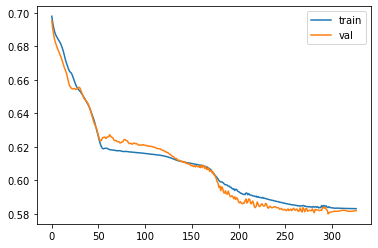

In [340]:
import matplotlib.pyplot as plt

plt.plot(trainLoss_list, label='train')
plt.plot(valLoss_list, label='val')
plt.legend()
plt.show()

In [341]:
import csv

# 開啟CSV檔案
with open('../new_test_data.csv', 'r') as csv_file:
    # 讀取CSV檔案
    csv_reader = csv.reader(csv_file)
    
    # 開啟TXT檔案
    with open('./new_test_data.txt', 'w') as txt_file:
        # 寫入TXT檔案
        for row in csv_reader:
            txt_file.write(' '.join(row) + '\n')


FileNotFoundError: [Errno 2] No such file or directory: '../new_test_data.csv'

# 測試

In [ ]:
import torch
import pandas as pd

# 載入模型
model = torch.load('checkpoint.pt')

# # 讀取CSV檔案
# data = pd.read_csv('/home/stannyho/Downloads/link_pre/new_test_data.csv')

import pandas as pd

data_path = "./new_test_data.txt"

with open(data_path, "r") as f:
    all_txt_str = f.read().split("\n")
    txt_list = [txt_str.split(" ") for txt_str in all_txt_str[1:]]
    edge_df = pd.DataFrame(txt_list, columns=["node_pair_id","node1","node2"])

edge_df = edge_df.dropna()
print(edge_df)


node_attr_ts = th.ones(len(encode)).float().reshape(-1, 1)
edge_index_ts = th.tensor([from_list, to_list]).long()
from torch_geometric.data import Data

test_data = Data(x=node_attr_ts, edge_index=edge_index_ts, edge_attr=edge_label_ts)

print(data)

model = torch.load("checkpoint.pt")
model.eval()

test_pred = get_pred_no_grad(test_data, model)
test_loss = get_loss_in_eval(test_data, model)
test_target = test_data.edge_label.reshape(-1, 1)
test_accuracy = th.mean(((test_pred>0.5)==test_target).float())

print(test_target)
# # 進行預測
# with torch.no_grad():
#     y_pred_tensor = model(edge_index_ts, node_attr_ts, edge_label_ts)

# # 將預測結果轉換回DataFrame
# y_pred = pd.DataFrame(y_pred_tensor.numpy(), columns=['predicted_target'])

# # 合併預測結果到原始資料中
# result = pd.concat([data, y_pred], axis=1)

# # 輸出成新的CSV檔案
# result.to_csv('2.csv', index=False)

     node_pair_id  node1  node2
0               0  40963  40966
1               1   4544  49357
2               2  38726  38760
3               3   4636  38678
4               4  26789   5842
...           ...    ...    ...
5995         5995  28930  16004
5996         5996  10247  22013
5997         5997  22854  26234
5998         5998  38127  38215
5999         5999   1064  23907

[6000 rows x 3 columns]
Data(x=[7769, 1], edge_index=[2, 20832], edge_attr=[20832, 1], edge_label=[20832, 1])


AttributeError: 'GlobalStorage' object has no attribute 'edge_label_index'